In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
from tsmoothie.smoother import GaussianSmoother
import spikeinterface
import spikeinterface.full as si



In [10]:
import sys
sys.path.insert(0, '/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis_MAINBRANCH/IPNAnalysis')
from helper_functions import detect_peaks



In [11]:
from mea_analysis_routine import preprocess
from mea_analysis_routine import setup_logger

In [12]:
local_path= '/mnt/Vol20tb1/PrimaryNeuronData/MaxTwo/CDKL5_R59X_10112024_PS/CDKL5_R59X_10112024_PS/241108/M07305/Network/000226/data.raw.h5' #network data from chip 16848


recording1 = si.read_maxwell(local_path,stream_id='well004')

#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#end_time = int((total_recording-1))
start_time = 0
end_time = 300

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

def preprocess(recording):

    # 1. Convert to Signed (Essential for Maxwell)
    recording = si.unsigned_to_signed(recording)
    
    # 2. REMOVE DC OFFSET (Highpass Only)
    # Don't lowpass (freq_max). Let KS4 see the sharp spike details.
    # KS4 expects data centered at 0.
    recording = si.highpass_filter(recording, freq_min=300)

    # 3. LOCAL Common Reference (Critical for Superbursts)
    # Instead of 'global', use 'local'.
    # This removes local electrical noise without deleting network-wide bursts.
    # radius=250um is a good balance for Maxwell chips.
    try:
        radius = 350
        recording = si.common_reference(
            recording, 
            reference='local', 
            operator='median', 
            local_radius=(70, radius) # radius in um
        )
    except Exception as e:
        # Fallback if channel locations aren't loaded correctly
        print(f"Local CMR failed ({e}), falling back to Global")
        recording = si.common_reference(recording, reference='global', operator='median')

    recording.annotate(is_filtered=True)

    # 4. Enforce float32 -> int16 conversion 
    # KS4 runs faster on int16. Maxwell Raw is float/int mix sometimes.
    # This scale step ensures the dynamic range fits into int16 without clipping.
    # (Optional but recommended if you aren't already handling dtype elsewhere)
    if recording.get_dtype() != 'int16':
        recording = si.scale(recording, dtype='int16')

    return recording


recording_chunk = preprocess(recording1)

The h5 compression library for Maxwell is already located in /home/mmp/hdf5_plugin_path_maxwell/libcompression.so!
Sampling frequency: 10000.0
Number of channels: 996
Number of segments: 1
total_recording: 300.08 s


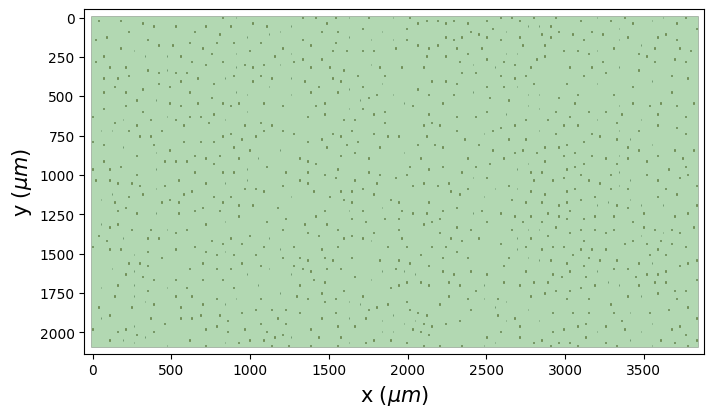

In [13]:
fig,ax = plt.subplots(figsize=(8,8))
si.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
ax.invert_yaxis()

In [14]:
si.get_default_sorter_params('kilosort4')

{'fs': 30000,
 'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'nt': 61,
 'shift': None,
 'scale': None,
 'artifact_threshold': inf,
 'nskip': 25,
 'whitening_range': 32,
 'highpass_cutoff': 300,
 'binning_depth': 5,
 'sig_interp': 20,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'nt0min': None,
 'dmin': None,
 'dminx': 32,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'max_channel_distance': 32,
 'max_peels': 100,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_neighbors': 10,
 'cluster_downsampling': 1,
 'max_cluster_subset': 25000,
 'x_centers': None,
 'duplicate_spike_ms': 0.25,
 'position_limit': 100,
 'do_CAR': True,
 'invert_sign': False,
 'save_extra_vars': False,
 'save_preprocessed_copy': False,
 'torch_device': 'auto',
 'bad_channels': None,
 'clear_cache': False,
 'do_correction': True,
 'skip_kilosort_preprocessi

In [15]:
job_kwargs = {
    'n_jobs': 32,
    'chunk_size': fs,
    'progress_bar': True
}
recording_chunk.save(
    folder=f"./binary",
    format='binary',
    overwrite=True,
    **job_kwargs
)
recording_chunk = si.load(
    f"./binary"
)

write_binary_recording 
engine=process - n_jobs=32 - samples_per_chunk=10,000 - chunk_memory=19.00 MiB - total_memory=607.91 MiB - chunk_duration=1.00s


write_binary_recording (workers: 32 processes):   0%|          | 0/301 [00:00<?, ?it/s]

In [16]:

analyzer_folder = "./analyzer_output"
args={'sorter' :'kilosort4'}
ks_params ={
                        'batch_size': 10000,
                        'clear_cache': True,
                        'invert_sign': True,
                        'cluster_downsampling': 20,
                        'max_cluster_subset': None,
                        'nblocks':0,
                        'dmin':17,
                        'do_correction': False,
                        
                    }
                    
sorting_obj = si.run_sorter_local(
                        sorter_name=args['sorter'],
                        recording=recording_chunk,
                        folder=analyzer_folder,
                        delete_output_folder=False,
                        verbose=True,
                        with_output=True,
                        **ks_params
                    )

kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 3000800
kilosort.run_kilosort: N seconds: 300.08
kilosort.run_kilosort: N batches: 301
kilosort.run_kilosort: Preprocessing filters computed in 0.53s; total 0.53s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    11.90 %
kilosort.run_kilosort: Mem used:     14.20 %     |       8.90 GB
kilosort.run_kilosort: Mem avail:    53.63 / 62.54 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:     0.00 %
kilosort.run_kilosort: GPU memory:   72.00 %     |     22.58   /    31.37 GB
kilosort.run_kilosort: Allocated:     0.04 %     |      0.01   /    31.37 GB
kilosort.run_kilosort: Max alloc:    89.89 %     |  

Skipping drift correction.


kilosort.spikedetect: Number of universal templates: 59045
kilosort.spikedetect: Detecting spikes...
100%|██████████| 301/301 [02:24<00:00,  2.08it/s]
kilosort.run_kilosort: 1745556 spikes extracted in 161.85s; total 162.48s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after spike detect (univ)
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     0.00 %
kilosort.run_kilosort: Mem used:     15.20 %     |       9.50 GB
kilosort.run_kilosort: Mem avail:    53.04 / 62.54 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    30.00 %
kilosort.run_kilosort: GPU memory:    2.69 %     |      0.84   /    31.37 GB
kilosort.run_kilosort: Allocated:     0.11 %     |      0.03   /    31.37 GB
kilosort.run_kilosort: Max alloc:    22.38 %     |      7.02   /    31.37 GB
kilosort.run_kilosort: ********************************************************
kilosort

kilosort4 run time 346.99s


In [17]:
  # Clean up sorting
sorting_obj = sorting_obj.remove_empty_units()
sorting_obj = si.remove_excess_spikes(
    sorting_obj,
    recording_chunk
)
sorting_obj = si.remove_duplicated_spikes( sorting_obj,censored_period_ms=0.1 )

In [18]:
# Optimal sparsity for HD-MEA (Maxwell Biosystems)
sparsity = si.estimate_sparsity(
    sorting=sorting_obj,
    recording=recording_chunk,
    method='radius',      # Best for spatial arrays
    radius_um=50,         # 40-70 um typical for HD-MEA (17.5 um pitch)
    peak_sign='neg'   # Most HD-MEA use negative peaks
)

#logging.info(f"Estimated sparsity: avg {sparsity.num_active_channels_per_unit().mean():.1f} channels/unit")

sorting_analyzer = si.create_sorting_analyzer(
    sorting_obj,
    recording_chunk,
    format="binary_folder",
    sparsity=sparsity,  # Use pre-computed ChannelSparsity object
    return_in_uV=True,
    folder=analyzer_folder,overwrite=True
)

estimate_sparsity (no parallelization):   0%|          | 0/301 [00:00<?, ?it/s]

/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/spikeinterface/core/basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


In [19]:
# Check which extensions are already computed
existing_extensions = sorting_analyzer.get_loaded_extension_names()


# Get all available extensions
all_available = sorting_analyzer.get_computable_extensions()


# Determine which extensions need to be computed
missing_extensions = [ext for ext in all_available if ext not in existing_extensions]

if missing_extensions:
    

    
    # Compute missing extensions with error handling
    successfully_computed = []
    failed_extensions = []
    
    for ext_name in missing_extensions:
        try:
        
    
            
            # Compute individual extension
            sorting_analyzer.compute(ext_name, save=True, **job_kwargs)
            
        
            successfully_computed.append(ext_name)
            print(f"  ✓ {ext_name} completed")
            
        except Exception as e:
            print(f"  ✗ Failed to compute {ext_name}: {e}")
            failed_extensions.append(ext_name)
            
            # Only fail if it's a critical extension
            critical_extensions = ['waveforms', 'templates', 'noise_levels']
            if ext_name in critical_extensions:
                raise RuntimeError(f"Critical extension {ext_name} failed: {e}")
    
    
    if failed_extensions:
        print(f"Failed extensions (non-critical): {failed_extensions}")
else:
    print("All extensions already computed!")



  ✓ random_spikes completed


compute_waveforms (workers: 32 processes):   0%|          | 0/301 [00:00<?, ?it/s]

  ✓ waveforms completed
  ✓ templates completed


/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/spikeinterface/core/recording_tools.py:780: UserWarning: get_noise_levels(recording, num_chunks_per_segment=20) is deprecated
Now, you need to use get_noise_levels(recording, random_slices_kwargs=dict(num_chunks_per_segment=20, chunk_size=1000))
Please read get_random_recording_slices() documentation for more options.
  warnings.warn(msg)


noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

  ✓ noise_levels completed


amplitude_scalings (workers: 32 processes):   0%|          | 0/301 [00:00<?, ?it/s]

  ✓ amplitude_scalings completed
  ✓ correlograms completed
  ✓ isi_histograms completed


Fitting PCA:   0%|          | 0/712 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/712 [00:00<?, ?it/s]

  ✓ principal_components completed


spike_amplitudes (workers: 32 processes):   0%|          | 0/301 [00:00<?, ?it/s]

  ✓ spike_amplitudes completed


spike_locations (workers: 32 processes):   0%|          | 0/301 [00:00<?, ?it/s]

  ✓ spike_locations completed


/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


  ✓ template_metrics completed
  ✓ template_similarity completed
  ✓ unit_locations completed


/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1721: RuntimeWarning: invalid value encountered in sqrt
  std_noise = np.sqrt(std_noise**2 - total_variance)
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:163: UserWarning: No bin is selected to test cutoff. Please increase low_quantile. Setting noise cutoff and ratio to NaN
  warnings.warn(
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:174: UserWarning: No bin is selected as the reference region. Please increase high_quantile. Setting noise cutoff to NaN
  warnings.warn(


calculate_pc_metrics:   0%|          | 0/712 [00:00<?, ?it/s]

/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/spikeinterface/qualitymetrics/pca_metrics.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  VI = np.linalg.inv(np.cov(pcs_for_this_unit.T))
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


  ✓ quality_metrics completed


/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis_MAINBRANCH/IPNAnalysis/helper_functions.py:190: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_isi_within = np.cov(isis_within_bursts) if isis_within_bursts.size > 0 else np.nan
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/si_ks4/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[Tonic filter] Removing 18 tonic units: [2, 7, 28, 41, 74, 81, 107, 113, 125, 128]
[Adaptive σ] median ISI = 2.30 ms → σ = 2.00 bins


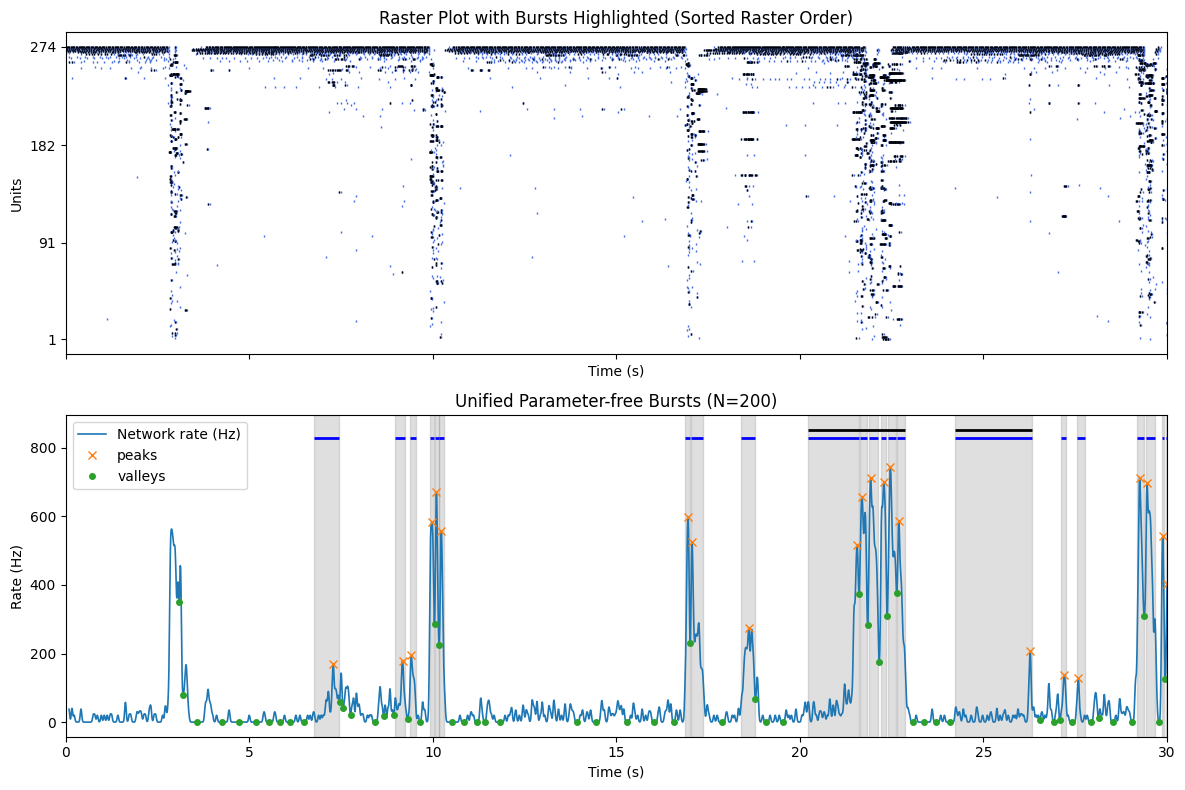

In [20]:
 # Extract metrics
qual_metrics = sorting_analyzer.get_extension('quality_metrics').get_data()
template_metrics = sorting_analyzer.get_extension('template_metrics').get_data()
from mea_analysis_routine import automatic_curation

# Filter units

update_qual_metrics, rejected_record = automatic_curation(qual_metrics)

non_violated_units = update_qual_metrics.index.values
numunits = len(non_violated_units)


# Generate spike train analysis
fs = recording_chunk.get_sampling_frequency()
frame_start = 0
time_in_s = None
if time_in_s is None:
    time_in_s = (recording_chunk.get_num_frames() / fs ) -1
frame_end = recording_chunk.get_num_frames()                                            ##for the resume option it is required to reload the recording chunk
spike_times = {}

for idx, unit_id in enumerate(non_violated_units):
    spike_train = sorting_obj.get_unit_spike_train(
        unit_id,
        start_frame=frame_start,
        end_frame=frame_end
    )
    if len(spike_train) > 0:
        spike_times[idx] = spike_train / float(fs)

#np.save(f"./analyzer_output/spikesorted_spike_times_dict.npy", spike_times)

##BURST ANALYSIS CODE

fig, axs = plt.subplots(2, 1, figsize=(12, 8),sharex=True)
# Define the ISI threshold for burst detection (e.g., 0.1 seconds)
isi_threshold = 0.1
# Detect bursts for each unit
import helper_functions as helper
burst_statistics = helper.detect_bursts_statistics(spike_times, isi_threshold)
bursts = [unit_stats['bursts'] for unit_stats in burst_statistics.values()]
# Extracting ISIs as combined arrays
all_isis_within_bursts = np.concatenate([stats['isis_within_bursts'] for stats in burst_statistics.values() if stats['isis_within_bursts'].size > 0])
all_isis_outside_bursts = np.concatenate([stats['isis_outside_bursts'] for stats in burst_statistics.values() if stats['isis_outside_bursts'].size > 0])
all_isis = np.concatenate([stats['isis_all'] for stats in burst_statistics.values() if stats['isis_all'].size > 0])

# Calculate combined statistics
mean_isi_within_combined = np.mean(all_isis_within_bursts) if all_isis_within_bursts.size > 0 else np.nan
cov_isi_within_combined = np.cov(all_isis_within_bursts) if all_isis_within_bursts.size > 0 else np.nan

mean_isi_outside_combined = np.mean(all_isis_outside_bursts) if all_isis_outside_bursts.size > 0 else np.nan
cov_isi_outside_combined = np.cov(all_isis_outside_bursts) if all_isis_outside_bursts.size > 0 else np.nan

mean_isi_all_combined = np.mean(all_isis) if all_isis.size > 0 else np.nan
cov_isi_all_combined = np.cov(all_isis) if all_isis.size > 0 else np.nan

# Calculate spike counts for each unit
spike_counts = {unit: len(times) for unit, times in spike_times.items()}

# Sort units by ascending spike counts
sorted_units = sorted(spike_counts, key=spike_counts.get)

axs[0]= helper.plot_raster_with_bursts(axs[0],spike_times, bursts,sorted_units=sorted_units, title_suffix="(Sorted Raster Order)")

# Call the plot_network_activity function and pass the SpikeTimes dictionary
#axs[1],network_data= helper.plot_network_bursts(axs[1],spike_times, figSize=(8, 4),binSize=0.1, gaussianSigma=0.2,min_peak_distance=10, thresholdBurst=2)
from parameter_free_burst_detector import plot_network_bursts
axs[1],network_data= plot_network_bursts(axs[1],spike_times)





plt.tight_layout()
plt.xlim(0, 30)
plt.savefig(f"./analyzer_output/spike_sorted_raster_plot.svg", format="svg")
plt.show()


In [ ]:
full_path = '/mnt/disk15tb/mmpatil/Axontracking/000026/data.raw.h5'
rec_id = 0
common_el = list(range(30000))
while rec_id < 3: #True:
    rec_name = 'rec' + '%0*d' % (4, rec_id)
    try:   
        rec = si.MaxwellRecordingExtractor(full_path,stream_name='well000',rec_name=rec_name)
        rec_el = rec.get_property("contact_vector")["electrode"]
        common_el = list(set(common_el).intersection(rec_el))
        rec_id += 1
    except Exception:
        break
            

In [ ]:
rec_id


In [ ]:
rec_list = []
for r in range(rec_id): #rec_id
    rec_name = 'rec' + '%0*d' % (4, r)
    rec = si.MaxwellRecordingExtractor(full_path,stream_name='well000',rec_name=rec_name)
    ch_id = rec.get_property("contact_vector")['device_channel_indices']
    rec_el = rec.get_property("contact_vector")["electrode"]
    
    chan_idx = [np.where(rec_el == el)[0][0] for el in common_el]
    print(f'x{rec.get_property("contact_vector")["x"][chan_idx]}y{rec.get_property("contact_vector")["y"][chan_idx]}')
    sel_channels = rec.get_channel_ids()[chan_idx]
    rec_centered = si.filter(rec, band=[150,4999])
    rec_list.append(rec_centered.channel_slice(sel_channels, renamed_channel_ids=list(range(len(chan_idx)))))

multirecording = si.concatenate_recordings(rec_list)

In [3]:
full_path = '/mnt/disk20tb/PrimaryNeuronData/Maxtwo/Folic_Acid_T2/Folic_Acid_T2/240209/M07038/ActivityScan/000047/data.raw.h5'
import h5py
stream_id = "well001"
h5 = h5py.File(full_path, mode="r")
rec_names = list(h5["wells"][stream_id].keys())
recs =list()
for rec_name in rec_names:
    recs.append(si.MaxwellRecordingExtractor(full_path,stream_name=stream_id,rec_name=rec_name))

aggregated_rec = si.aggregate_channels(recs)
print(aggregated_rec)

ValueError: Sortings don't have the same sampling_frequency/num_segments/dtype/num samples

In [29]:
print([x for x in h5['wells'].keys()])

['well000', 'well001', 'well002', 'well003', 'well004', 'well005']


In [26]:
print(h5['wellplate']['version'])

<HDF5 dataset "version": shape (1,), type "|S23">


In [ ]:
chan_idx

In [ ]:
multirecording.get_channel_ids()

In [ ]:
#Reading the file, BP filtering
#path of the network file
local_path= '/mnt/disk15tb/mmpatil/Axontracking/000026/data.raw.h5' #network data from chip 16848
recordings =list()
for recnames in ['rec0000', 'rec0001', 'rec0002', 'rec0003', 'rec0004', 'rec0005', 'rec0006', 'rec0007', 'rec0008', 'rec0009', 'rec0010', 'rec0011', 'rec0012', 'rec0013', 'rec0014', 'rec0015', 'rec0016', 'rec0017', 'rec0018', 'rec0019', 'rec0020', 'rec0021', 'rec0022', 'rec0023', 'rec0024', 'rec0025', 'rec0026', 'rec0027', 'rec0028', 'rec0029', 'rec0030', 'rec0031', 'rec0032', 'rec0033', 'rec0034', 'rec0035', 'rec0036', 'rec0037', 'rec0038', 'rec0039']:
    recordings.append(se.read_maxwell(local_path,stream_id='well000',rec_name=recnames)) #well000 - well005 for maxtwo 

recording1 = si.aggregate_channels(recordings)

#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=300, freq_max=3000)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=180*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")

In [2]:
local_path= '/mnt/disk20tb/240425/18832/Network/000020/data.raw.h5' #network data from chip 16848


recording1 = se.read_maxwell(local_path,stream_id='well000')

#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=300, freq_max=3000)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=300*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")

Sampling frequency: 20000.0
Number of channels: 999
Number of segments: 1
total_recording: 300.08 s
chunk duration: 300.0 s


## RUnnig sorting

In [ ]:
traces = recording_chunk.get_traces(start_frame=100, end_frame=50000*15, segment_index=0,return_scaled=True)


In [ ]:
traces = recording_chunk.get_traces(start_frame=290500, end_frame=291800, segment_index=0,return_scaled=True)
plt.figure(figsize=(12,2))
plt.plot(traces[:,500])
plt.savefig('/home/mmp/Documents/traces/fulltrace.svg',format='svg')
plt.show()

In [ ]:
traces = recording_chunk.get_traces(start_frame=278860, end_frame=278910, segment_index=0,return_scaled=True)
plt.figure(figsize=(3,4))
plt.plot(traces[:,500])
plt.savefig('/home/mmp/Documents/traces/zoomedin.svg',format='svg')
plt.show()

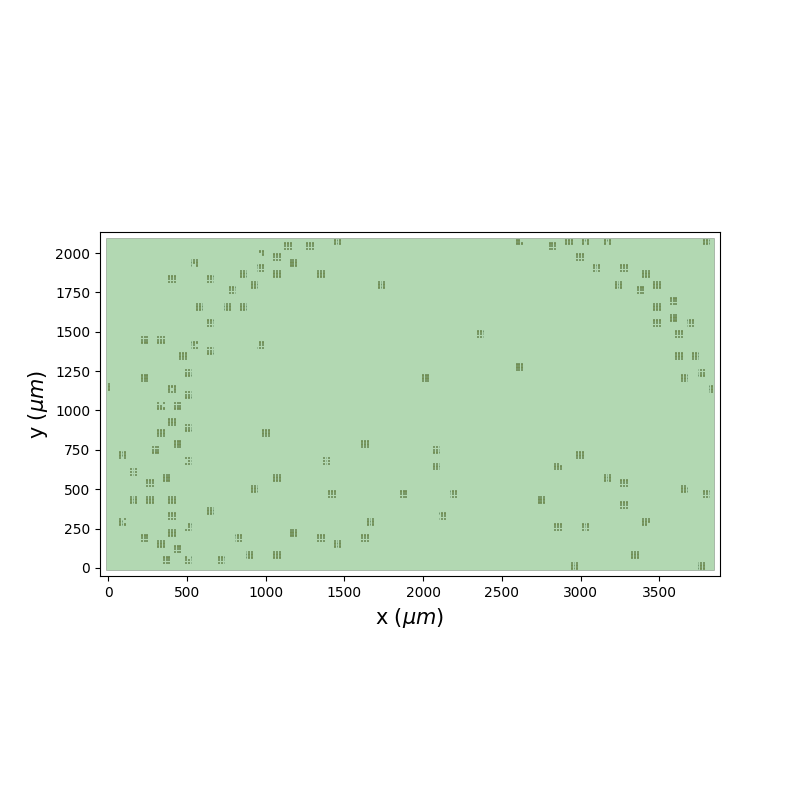

In [4]:
%matplotlib widget
fig,ax = plt.subplots(figsize=(8,8))
si.plot_probe_map(recording1,ax=ax,with_channel_ids=False)


In [5]:
output_folder = "./sorting/organoid25apr_networkNU9_"

docker_image= "rohanmalige/benshalom:v3"

In [6]:
#aggregated_rec= aggregated_rec.save(fodler="./sorting/recordingtest",progress_bar=True,verbose=True)

default_KS2_params = si.get_default_sorter_params('kilosort2')
print(default_KS2_params)
#default_KS2_params['keep_good_only'] = True
default_KS2_params['detect_threshold'] = 5.5
# default_KS2_params['projection_threshold']=[18, 10]
default_KS2_params['n_jobs'] = 32
# global_job_kwargs = dict(n_jobs=32, total_memory="8G", progress_bar=True)
# si.set_global_job_kwargs(**global_job_kwargs)
sortingKS3 = si.run_sorter('kilosort2',recording=recording_chunk, output_folder=f'{output_folder}_KS',docker_image= docker_image,verbose=True,remove_existing_folder=True, **default_KS2_params)


{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'momentum': [20.0, 400.0], 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'lam': 10.0, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': ('matlab_files',), 'delete_recording_dat': False, 'n_jobs': 48, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}
installation_mode='auto' switching to installation_mode: 'github'
Starting container
Installing neo with pypi in container
Installing h5py with pypi in container
Running kilosort2 sorter inside rohanmalige/benshalom:v3
Stopping container


In [7]:

# loading the KS2 sorted object
sortingKS3 = sortingKS3.remove_empty_units()
sortingKS3 = spikeinterface.curation.remove_excess_spikes(sortingKS3,recording1) #Sometimes KS returns spikes outside the number of samples. < https://github.com/SpikeInterface/spikeinterface/pull/1378>

sortingKS3= sortingKS3.save(folder = f'{output_folder}_KS2',overwrite=True)
#sorting_KS3 = s.Kilosort2Sorter._get_result_from_folder('./sorting/FolicAcidT2M07038_2_KS/sorter_output')
total_units = sortingKS3.get_unit_ids()
print(len(total_units))
#print(len(total_units))
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids)



267
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72'
 '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85' '86'
 '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99' '100'
 '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '120' '121' '122' '123' '124'
 '125' '126' '127' '128' '129' '130' '131' '132' '133' '134' '135' '136'
 '137' '138' '139' '140' '141' '142' '143' '144' '145' '146' '147' '148'
 '149' '150' '151' '152' '153' '154' '155' '156' '157' '158' '159' '160'
 '161' '162' '163' '164' '165' '166' '167' '168' '169' '170' '171' '172'
 '173' '174' '175' '176' '177' '178' '179' '180' '181' '182'

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/core/basesorting.py:239: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


## Extracting the waveforms

In [8]:

job_kwargs = dict(n_jobs=32, chunk_duration="1s", progress_bar=True)
#waveforms = si.extract_waveforms(recording_chunk,sorting_KS3,folder="./waveformsblock1_7min",overwrite=True, ms_before=1., ms_after=2.,**job_kwargs)

#recording1.annotate(is_filtered=True)
waveforms = si.extract_waveforms(recording_chunk,sortingKS3,folder=f'{output_folder}_WF',overwrite=True,**job_kwargs)
print(waveforms)

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 999 channels - 267 units - 1 segments
  before:20 after:40 n_per_units:500 - sparse


In [ ]:
si.export_to_phy(waveform_extractor=waveforms,output_folder='./sorting/SPTAN1_1_16793_phy',**job_kwargs)

In [9]:
extremum_channels_ids =si.get_template_extremum_channel(waveforms,peak_sign ='both',mode='at_index')

In [10]:
extremum_channels_ids

{0: '386',
 1: '386',
 2: '386',
 3: '386',
 4: '386',
 5: '386',
 6: '386',
 7: '386',
 9: '386',
 10: '386',
 11: '386',
 12: '386',
 13: '386',
 14: '386',
 15: '386',
 16: '386',
 17: '386',
 18: '386',
 19: '386',
 20: '386',
 21: '386',
 22: '386',
 23: '386',
 24: '386',
 25: '386',
 26: '386',
 27: '386',
 28: '386',
 29: '386',
 31: '386',
 32: '386',
 33: '386',
 34: '386',
 35: '386',
 36: '386',
 37: '386',
 38: '386',
 39: '386',
 40: '386',
 41: '386',
 43: '386',
 44: '386',
 45: '386',
 46: '386',
 47: '386',
 48: '386',
 49: '386',
 50: '386',
 51: '386',
 52: '386',
 53: '386',
 57: '386',
 58: '386',
 59: '386',
 60: '386',
 61: '386',
 62: '386',
 63: '386',
 65: '386',
 66: '386',
 67: '386',
 68: '386',
 69: '386',
 70: '386',
 72: '386',
 73: '386',
 75: '386',
 76: '386',
 78: '386',
 79: '386',
 80: '386',
 81: '386',
 82: '386',
 83: '386',
 84: '386',
 85: '386',
 86: '386',
 88: '386',
 89: '386',
 90: '386',
 91: '386',
 92: '386',
 93: '386',
 94: '386',
 

In [ ]:
template = waveforms.get_template(5,mode='median')
template.shape

In [33]:
waveforms = si.load_waveforms('/mnt/disk15tb/mmpatil/MEA_Analysis/IPNAnalysis/sorting/KMB_RTT_18646_waveforms')
print(waveforms)
job_kwargs = dict(n_jobs=16, chunk_duration="1s", progress_bar=True)
sp.compute_spike_amplitudes(waveforms,load_if_exists=True,**job_kwargs)
metrics = qm.compute_quality_metrics(waveforms,load_if_exists=False,**job_kwargs)

WaveformExtractor: 994 channels - 348 units - 1 segments
  before:20 after:40 n_per_units:500 - sparse


extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1221: UserWarning: Amplitude PDF does not have a unique minimum! More spikes might be required for a correct amplitude_cutoff computation!
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:848: UserWarning: Units [0, 1, 4, 5, 6, 7, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 24, 25, 27, 30, 31, 32, 34, 35, 41, 42, 45, 46, 51, 52, 53, 54, 65, 67, 69, 70, 72, 78, 80, 82, 85, 86, 87, 88, 90, 92, 94, 95, 96, 98, 99, 102, 103, 104, 110, 112, 113, 114, 118, 124, 125, 126, 129, 130, 131, 132, 134, 135, 140, 141, 144, 148, 153, 155, 156, 159, 161, 162, 163, 164, 165, 168, 169, 170, 172, 173, 175, 177, 178, 179, 180, 181, 182, 183, 185, 186, 189, 190, 193, 195, 196, 197, 199, 202, 209, 210, 213, 218, 222, 223, 226, 227, 228, 229, 230, 231, 232, 236, 237, 239, 240, 247, 248, 250, 251, 252, 254, 256, 257, 258, 261, 262, 264, 265, 266, 268, 271, 272, 27

In [1]:
import mea_analysis_pipeline
import importlib
importlib.reload(mea_analysis_pipeline)

<module 'mea_analysis_pipeline' from '/mnt/disk15tb/mmpatil/MEA_Analysis/IPNAnalysis/mea_analysis_pipeline.py'>

In [34]:

updated_metrics = mea_analysis_pipeline.remove_violated_units(metrics)

In [35]:
non_violated = updated_metrics.index

In [ ]:
from spikeinterface.postprocessing import compute_spike_amplitudes, compute_principal_components
from spikeinterface.exporters import export_to_phy


_ = compute_principal_components(waveform_extractor=waveforms, n_components=3, mode='by_channel_global',**job_kwargs)

# the export process is fast because everything is pre-computed


In [ ]:
job_kwargs = dict(n_jobs=48, chunk_duration="1s", progress_bar=True)
sparsity = spikeinterface.core.compute_sparsity(waveforms ,method="radius", radius_um=40)
export_to_phy(waveform_extractor=waveforms, output_folder='/mnt/disk15tb/mmpatil/MEA_Analysis/IPNAnalysis/sorting/M07038_phy',sparsity=sparsity,**job_kwargs)

In [ ]:
display(update_qual_metrics)

In [ ]:
print(non_violated_units)

In [ ]:
len(non_violated_units)

In [ ]:
waveform_good = waveforms.select_units(non_violated_units,new_folder='./sorting/FolicAcidT2M07038_2_waveformsgood/')

In [ ]:
correlograms, bins = sp.compute_correlograms(waveform_good)

In [ ]:
correlograms.shape

In [ ]:
import matplotlib.pyplot as plt

# Extracting the correlation values between units 2 and 5 across all bins
# Adjusting indices for 0-based Python indexing
correlations = correlograms[2, 2, :]

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(correlations, bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Correlations Between Units 2 and 5 Across Bins')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()

In [ ]:
bins

In [ ]:
metrics = qm.compute_quality_metrics(waveform_good,load_if_exists=False,**job_kwargs)

In [ ]:
display(metrics)

In [ ]:
waveform_good = None

In [ ]:
waveform_good = si.load_waveforms('./sorting/waveformsgood_Folicacid10mg/')

In [ ]:
metrics = qm.compute_quality_metrics(waveform_good,load_if_exists=False,**job_kwargs)

In [ ]:
display(metrics)

{0: array([3.46815783e+03, 1.03369475e+03, 1.00720885e+00]), 1: array([3.20260745e+03, 1.22503994e+03, 1.43096136e+00]), 4: array([1.01551523e+03, 5.74822356e+02, 1.00000000e+00]), 5: array([1.01493177e+03, 5.73679868e+02, 1.00000000e+00]), 6: array([1.02182138e+03, 5.75870525e+02, 1.00000000e+00]), 7: array([1112.93228364,  997.17822916,    1.34162158]), 8: array([3.61921905e+03, 1.24049542e+03, 1.25387860e+00]), 9: array([921.78364456, 879.95928561,   1.        ]), 10: array([ 752.44689199, 1067.43588515,    1.26943001]), 11: array([906.24393614, 816.63102147,   1.        ]), 12: array([905.28882882, 816.92414591,   1.        ]), 13: array([904.81501925, 827.01263311,   1.        ]), 14: array([905.92381102, 816.08533527,   1.        ]), 15: array([ 858.38310118, 1469.82265423,    3.30718126]), 16: array([1.05701486e+03, 1.06391730e+03, 1.00000000e+00]), 17: array([3.27260446e+03, 1.08511269e+03, 1.70208774e+00]), 18: array([3.27257106e+03, 1.08512914e+03, 2.00550180e+00]), 19: array

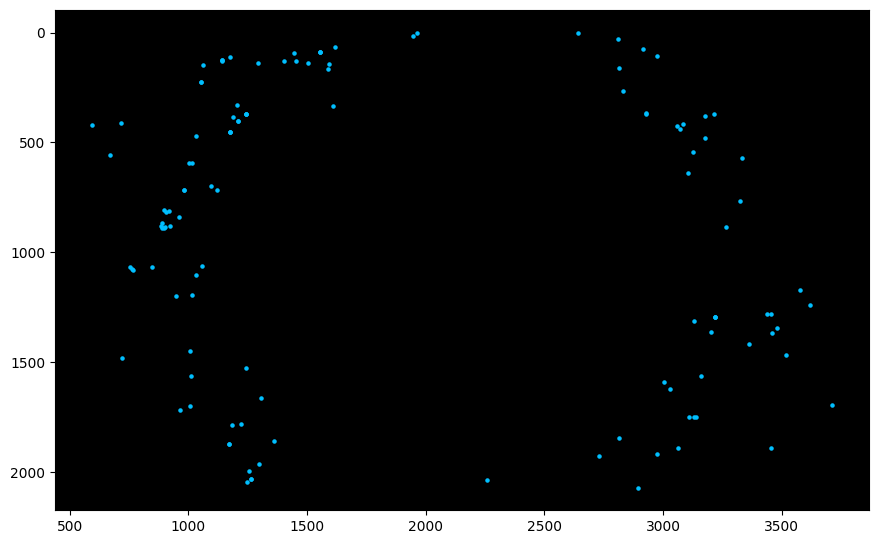

In [36]:

#locations = sp.compute_unit_locations(waveforms)
non_violated = updated_metrics.index
unit_ids = waveforms.unit_ids
locations = sp.compute_unit_locations(waveforms)
#print(locations)
unit_locations =dict(zip(unit_ids,locations))
print(unit_locations)
#np.savetxt("unitloc_10mins.txt",locations)
fig,ax = plt.subplots(figsize=(10.5,6.5))
#sw.plot_probe_map(mu,ax=ax,with_channel_ids=False)
ax.set_facecolor('#000000') 
print(len(non_violated))
for unit_id, (x,y,z) in unit_locations.items() :
    if unit_id in non_violated:
        ax.scatter(x,y, s=5,c='deepskyblue')
    
ax.invert_yaxis()
plt.savefig(f'/home/mmp/Documents/organoidKMB/REtt_unitlocations.svg',format='svg')

In [25]:
import pandas as pd

updated_metrics

,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8
0,0.007324,0.087263,0.036296,94.413757,7.41,2.100000,0.000000,0.0,630.0,1.0,0.0,0.0,1.327198,0.090,9.851611,0.152381,0.001587,0.0
1,0.015023,0.228086,0.087035,81.825256,4.22,2.916667,0.000000,0.0,875.0,1.0,0.0,0.0,2.278150,0.135,8.768378,0.069714,0.000000,0.0
3,0.001691,0.420412,0.088204,18.882751,5.23,2.040000,0.000000,0.0,612.0,1.0,0.0,0.0,1.305994,0.125,inf,0.098039,0.000000,0.0
5,0.010771,0.109274,0.064426,107.002258,8.43,2.000000,0.000000,0.0,600.0,1.0,0.0,0.0,2.124837,0.110,11.300419,0.190000,0.005000,0.0
6,0.001351,0.109935,0.045825,75.531006,6.89,11.756667,0.000000,0.0,3527.0,1.0,0.0,0.0,1.154775,0.005,8.124912,0.033173,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0.000316,NaN,NaN,75.531006,14.63,2.726667,0.747246,5.0,818.0,1.0,1.0,7.0,1.841130,NaN,7.733711,0.118582,0.001222,0.0
381,0.004009,0.246110,0.105217,37.765503,5.24,5.100000,0.085437,2.0,1530.0,1.0,0.0,0.0,1.326355,0.125,4.177794,0.051634,0.000000,0.0
383,0.000378,0.244141,0.113361,31.471252,4.60,2.293333,0.000000,0.0,688.0,1.0,0.0,0.0,1.258151,0.270,3.162011,0.074128,0.000000,0.0
384,0.004800,0.203662,0.105812,50.354004,6.47,3.436667,0.470384,5.0,1031.0,1.0,1.0,4.0,1.800363,0.325,5.435042,0.072745,0.001940,0.0


In [37]:
updated_metrics.to_excel('/home/mmp/Documents/organoidKMB/updated_metrics_RETT.xlsx', index=False)


In [38]:
wild_update_metrics = pd.read_excel('/home/mmp/Documents/organoidKMB/updated_metrics_WT.xlsx')

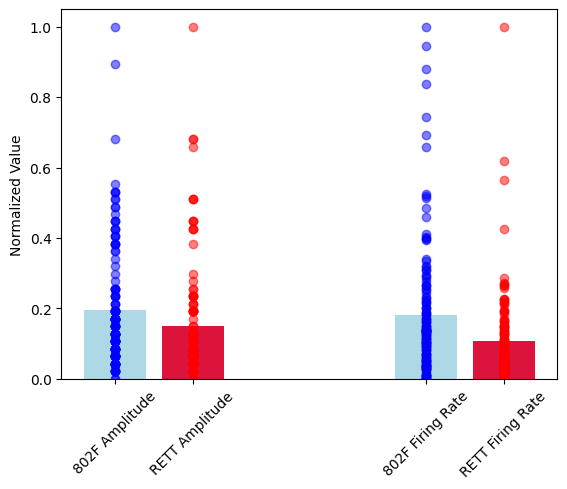

In [52]:
import matplotlib.pyplot as plt

# Calculate the minimum and maximum values of the amplitude_median column
min_wild_update_metrics = wild_update_metrics['amplitude_median'].min()
max_wild_update_metrics = wild_update_metrics['amplitude_median'].max()
min_updated_metrics = updated_metrics['amplitude_median'].min()
max_updated_metrics = updated_metrics['amplitude_median'].max()

# Calculate the minimum and maximum values of the firing_rate column
min_wild_update_firing_rate = wild_update_metrics['firing_rate'].min()
max_wild_update_firing_rate = wild_update_metrics['firing_rate'].max()
min_updated_firing_rate = updated_metrics['firing_rate'].min()
max_updated_firing_rate = updated_metrics['firing_rate'].max()

# Normalize the data using min-max normalization
normalized_minmax_wild_update_metrics = wild_update_metrics['amplitude_median'].apply(lambda x: (x - min_wild_update_metrics) / (max_wild_update_metrics - min_wild_update_metrics))
normalized_minmax_updated_metrics = updated_metrics['amplitude_median'].apply(lambda x: (x - min_updated_metrics) / (max_updated_metrics - min_updated_metrics))
normalized_minmax_wild_update_firing_rate = wild_update_metrics['firing_rate'].apply(lambda x: (x - min_wild_update_firing_rate) / (max_wild_update_firing_rate - min_wild_update_firing_rate))
normalized_minmax_updated_firing_rate = updated_metrics['firing_rate'].apply(lambda x: (x - min_updated_firing_rate) / (max_updated_firing_rate - min_updated_firing_rate))

# Set the x-axis positions for the bars
x_pos = [1, 1.5, 3, 3.5]

# Calculate the means of the normalized metrics to plot
mean_normalized_wild_amplitude = normalized_minmax_wild_update_metrics.mean()
mean_normalized_updated_amplitude = normalized_minmax_updated_metrics.mean()
mean_normalized_wild_firing_rate = normalized_minmax_wild_update_firing_rate.mean()
mean_normalized_updated_firing_rate = normalized_minmax_updated_firing_rate.mean()

# Set the heights for the bars
heights = [
    mean_normalized_wild_amplitude, 
    mean_normalized_updated_amplitude, 
    mean_normalized_wild_firing_rate, 
    mean_normalized_updated_firing_rate
]

# Set the colors for the bars
colors = ['lightblue', 'crimson', 'lightblue', 'crimson']

# Bar plot for the normalized mean amplitude_median column
plt.bar(x_pos, heights, color=colors, width=0.4)

# Scatter plot for the remaining series values
plt.scatter([1]*len(normalized_minmax_wild_update_metrics), normalized_minmax_wild_update_metrics, color='blue', alpha=0.5)
plt.scatter([1.5]*len(normalized_minmax_updated_metrics), normalized_minmax_updated_metrics, color='red', alpha=0.5)
plt.scatter([3]*len(normalized_minmax_wild_update_firing_rate), normalized_minmax_wild_update_firing_rate, color='blue', alpha=0.5)
plt.scatter([3.5]*len(normalized_minmax_updated_firing_rate), normalized_minmax_updated_firing_rate, color='red', alpha=0.5)

plt.ylabel('Normalized Value')
plt.xticks(x_pos, ['802F Amplitude', 'RETT Amplitude', '802F Firing Rate', 'RETT Firing Rate'], rotation=45)

plt.show()

